In [21]:
import torch
import arviz as az
from scipy.optimize import curve_fit
from bokeh.plotting import figure, show,output_file, save
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Spectral
from bokeh.models import Slope, Div
from bokeh.io import curdoc,output_notebook,export_png
from bokeh.layouts import column,gridplot

from sklearn.metrics import r2_score
#from seaborn import clustermap
from bokeh.models import Band, ColumnDataSource
import pandas as pd
TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,examine,help"

In [22]:
PM25=pd.read_excel("../data/pm_flow.xlsx")
train,test=PM25.loc[PM25.label==0,:],PM25.loc[PM25.label==1,:]

In [23]:
gpr=torch.load("../models/PM2.5_flow",weights_only=False,map_location='cuda')

In [24]:
gpr_bc=torch.load("../models/bc_flow",weights_only=False,map_location='cuda')

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
linmod=torch.linspace(0,52,800).to(device)
pm25_model,pm25_model_std=gpr(linmod,full_cov=True)

linmod_np=linmod.cpu().detach().numpy()
pm25_model_np,pm25_model_std_np=pm25_model.cpu() .detach().numpy().copy(),pm25_model_std.diag().sqrt().cpu() .detach().numpy().copy()

lower1 = pm25_model_np - pm25_model_std_np
upper1 = pm25_model_np + pm25_model_std_np
data1=pd.DataFrame([linmod_np,lower1,upper1],index=["corrected_week","lower","upper"]).T
data1 = ColumnDataSource(data1.reset_index())

In [27]:

bc_model,bc_model_std=gpr_bc(linmod, full_cov=True)
bc_model_np,bc_model_std_np=bc_model.cpu().detach().numpy().copy(),bc_model_std.cpu().diag().sqrt().detach().numpy().copy()

lower1_bc = bc_model_np - bc_model_std_np
upper1_bc = bc_model_np + bc_model_std_np
data1_bc=pd.DataFrame([linmod_np,lower1_bc,upper1_bc],index=["corrected_week","lower_bc","upper_bc"]).T
data1_bc = ColumnDataSource(data1_bc.reset_index())

In [28]:
std=train.sort_values("flow").rolling(50, min_periods=1,closed='both',step=1).std()
mean=train.sort_values("flow").rolling(50, min_periods=1,closed='both',step=1).mean()
std.columns=std.columns+"_std"
mean=pd.concat([mean,std],axis=1)
lower1_std = mean.pm_final - mean.pm_final_std
upper1_std = mean.pm_final + mean.pm_final_std
lower1_bc_std  = mean.sv_final - mean.sv_final_std
upper1_bc_std  = mean.sv_final + mean.sv_final_std
mean["lower1_std_pm"]=lower1_std
mean["upper1_std_pm"]=upper1_std
mean["lower1_std_bc"]=lower1_bc_std
mean["upper1_std_bc"]=upper1_bc_std

mean=mean.dropna()
mean1 = ColumnDataSource(mean.reset_index())

In [9]:
output_notebook()


Loading BokehJS ...

In [10]:
train

,Unnamed: 0,household,flow,pm_final,sv_final,visit,constrution_year,Area,floor_level,powerplant,...,airport,farmland,industrial,carpet,cookerhood,passive,gastove,fireplace,corrected_week,label
1,1,225,3.954708,4.545255,0.277071,3,1975.662144,74.803475,1,0.000000,...,0.000000,0.000000e+00,20780.223838,0.049034,20.992970,86.705459,355.320195,-1.523897,24.683831,0
2,2,393,4.102849,9.976309,0.491257,2,1960.521663,145.767790,0,0.000000,...,324.868422,2.287227e+05,3914.751215,362.930174,270.197467,3.397334,-10.140525,-2.288387,16.124674,0
3,3,143,3.755394,126.081796,1.596223,3,1942.855513,96.770278,0,103.106902,...,139.877291,6.341575e+04,30.653397,0.000000,361.469009,361.383175,6.660279,5.345446,18.214526,0
4,4,109,3.929210,15.634916,1.364662,2,1952.116983,159.142045,0,0.000000,...,199.928582,3.452725e+05,0.000000,0.779159,368.531467,369.356873,-5.145932,7.477185,32.247296,0
5,5,327,4.155364,6.915963,0.329383,1,1958.141628,94.681696,0,79.703759,...,0.000000,7.296237e+03,66467.396419,0.000000,364.278067,0.000000,3.994294,0.925205,7.875321,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,1115,120,3.948366,8.365918,0.341129,2,1933.608661,108.532951,1,2277.209051,...,48.198813,7.890186e+03,75.612819,0.128077,290.616286,0.359627,0.029098,1.100404,19.675348,0
1116,1116,147,4.130750,13.928526,0.712053,3,1949.408786,168.869662,0,0.000000,...,26.960634,1.042082e+06,250.744515,365.000000,361.313452,0.000000,-4.173096,168.310554,43.354914,0
1117,1117,195,4.356774,2.523000,0.587962,1,1927.355494,83.431451,0,110.426996,...,10.579000,1.328781e+03,3314.959744,0.219452,7.503921,0.000000,305.221812,36.608417,41.052617,0
1118,1118,413,3.989733,11.958373,1.526529,2,1944.305327,143.032250,0,8.049952,...,0.000000,4.035798e+04,0.000000,0.399914,226.399305,0.000000,158.027315,223.857955,9.322257,0


In [11]:
p = figure(x_range=(3.6,4.6),y_range=(0,60));
p.title.text = r"$$ PM_{2.5}$$ calibration of flow";
p.xgrid.grid_line_color=None;
p.ygrid.grid_line_alpha=0.5;
p.line(mean.flow, mean.pm_final, line_width=3,color="green",legend_label="mean_roll=100");
p.line(linmod_np, pm25_model_np, line_width=3,color="red",legend_label="Gaussion model");
p.scatter(train.flow, y=train.pm_final, color="blue", marker="dot", size=20, alpha=0.4,legend_label="raw points");
band = Band(base="corrected_week", lower="lower1_std_pm", upper="upper1_std_pm",source=mean1, fill_color="red", line_color="black",fill_alpha=0.5);
band1 = Band(base="corrected_week", lower="lower", upper="upper",source=data1,fill_alpha=0.5, fill_color="blue", line_color="black");

p.add_layout(band);
p.add_layout(band1);
p.xaxis.axis_label = r'$$Week \ of \ the \ year$$';
p.yaxis.axis_label = r'$$\frac{\mu g}{m^3} $$';
p1 = figure(x_range=(3.6,4.6),y_range=(0,3));
p1.title.text = r" Black Carbon calibration of flow";
p1.xgrid.grid_line_color=None;
p1.ygrid.grid_line_alpha=0.5;
p1.line(mean.flow, mean.sv_final, line_width=3,color="green",legend_label="mean_roll=100");
p1.line(linmod_np, bc_model_np, line_width=3,color="red",legend_label="Gaussion model");
p1.scatter(train.flow, y=train.sv_final, color="blue", marker="dot", size=20, alpha=0.8,legend_label="raw points");
band2 = Band(base="corrected_week", lower="lower_bc", upper="upper_bc",source=data1_bc, fill_color="blue", line_color="black",fill_alpha=0.5);
band3 = Band(base="corrected_week", lower="lower1_std_bc", upper="upper1_std_bc",source=mean1, fill_color="red", line_color="black",fill_alpha=0.5);
p1.add_layout(band3);
p1.add_layout(band2);

p1.xaxis.axis_label = r'$$Week \ of \ the \ year$$';
p1.yaxis.axis_label = r'r$$ \frac{\mu g}{m^3} $$';
p1.legend.title_text_font_size = "16px";
p.legend.title_text_font_size = "16px";
p.xaxis.axis_label_text_font_size = "14px";
p.yaxis.axis_label_text_font_size = "14px";
p1.xaxis.axis_label_text_font_size = "14px";
p1.yaxis.axis_label_text_font_size = "14px";
p1.yaxis.axis_label_text_font_style = "bold";
p1.xaxis.axis_label_text_font_style = "bold";
p.yaxis.axis_label_text_font_style = "bold";
p.xaxis.axis_label_text_font_style = "bold";
grid =  gridplot([[p, p1]], width=500, height=500);

show(column(grid));

In [12]:
test_1=gpr_bc(torch.tensor(test.flow.values).float().to(device))[0].cpu().detach().numpy()
test_2=gpr(torch.tensor(test.flow.values).float().to(device))[0].cpu().detach().numpy()

In [13]:
r2_score(test.sv_final,test_1),r2_score(test.pm_final,test_2)

(0.001678553628418511, -0.15197958117139598)

In [14]:
pyro_data=az.from_json("../Arviz_stats/mcmc_pm25_flow.json")


In [15]:
az.style.use("arviz-doc")

ax = az.plot_trace(pyro_data,backend='bokeh')

In [16]:
ax = az.plot_density(
    pyro_data,backend='bokeh'
)

array([[<Axes: ylabel='kernel.variance'>, <Axes: >],
       [<Axes: xlabel='kernel.lengthscale', ylabel='noise'>,
        <Axes: xlabel='kernel.variance'>]], dtype=object)

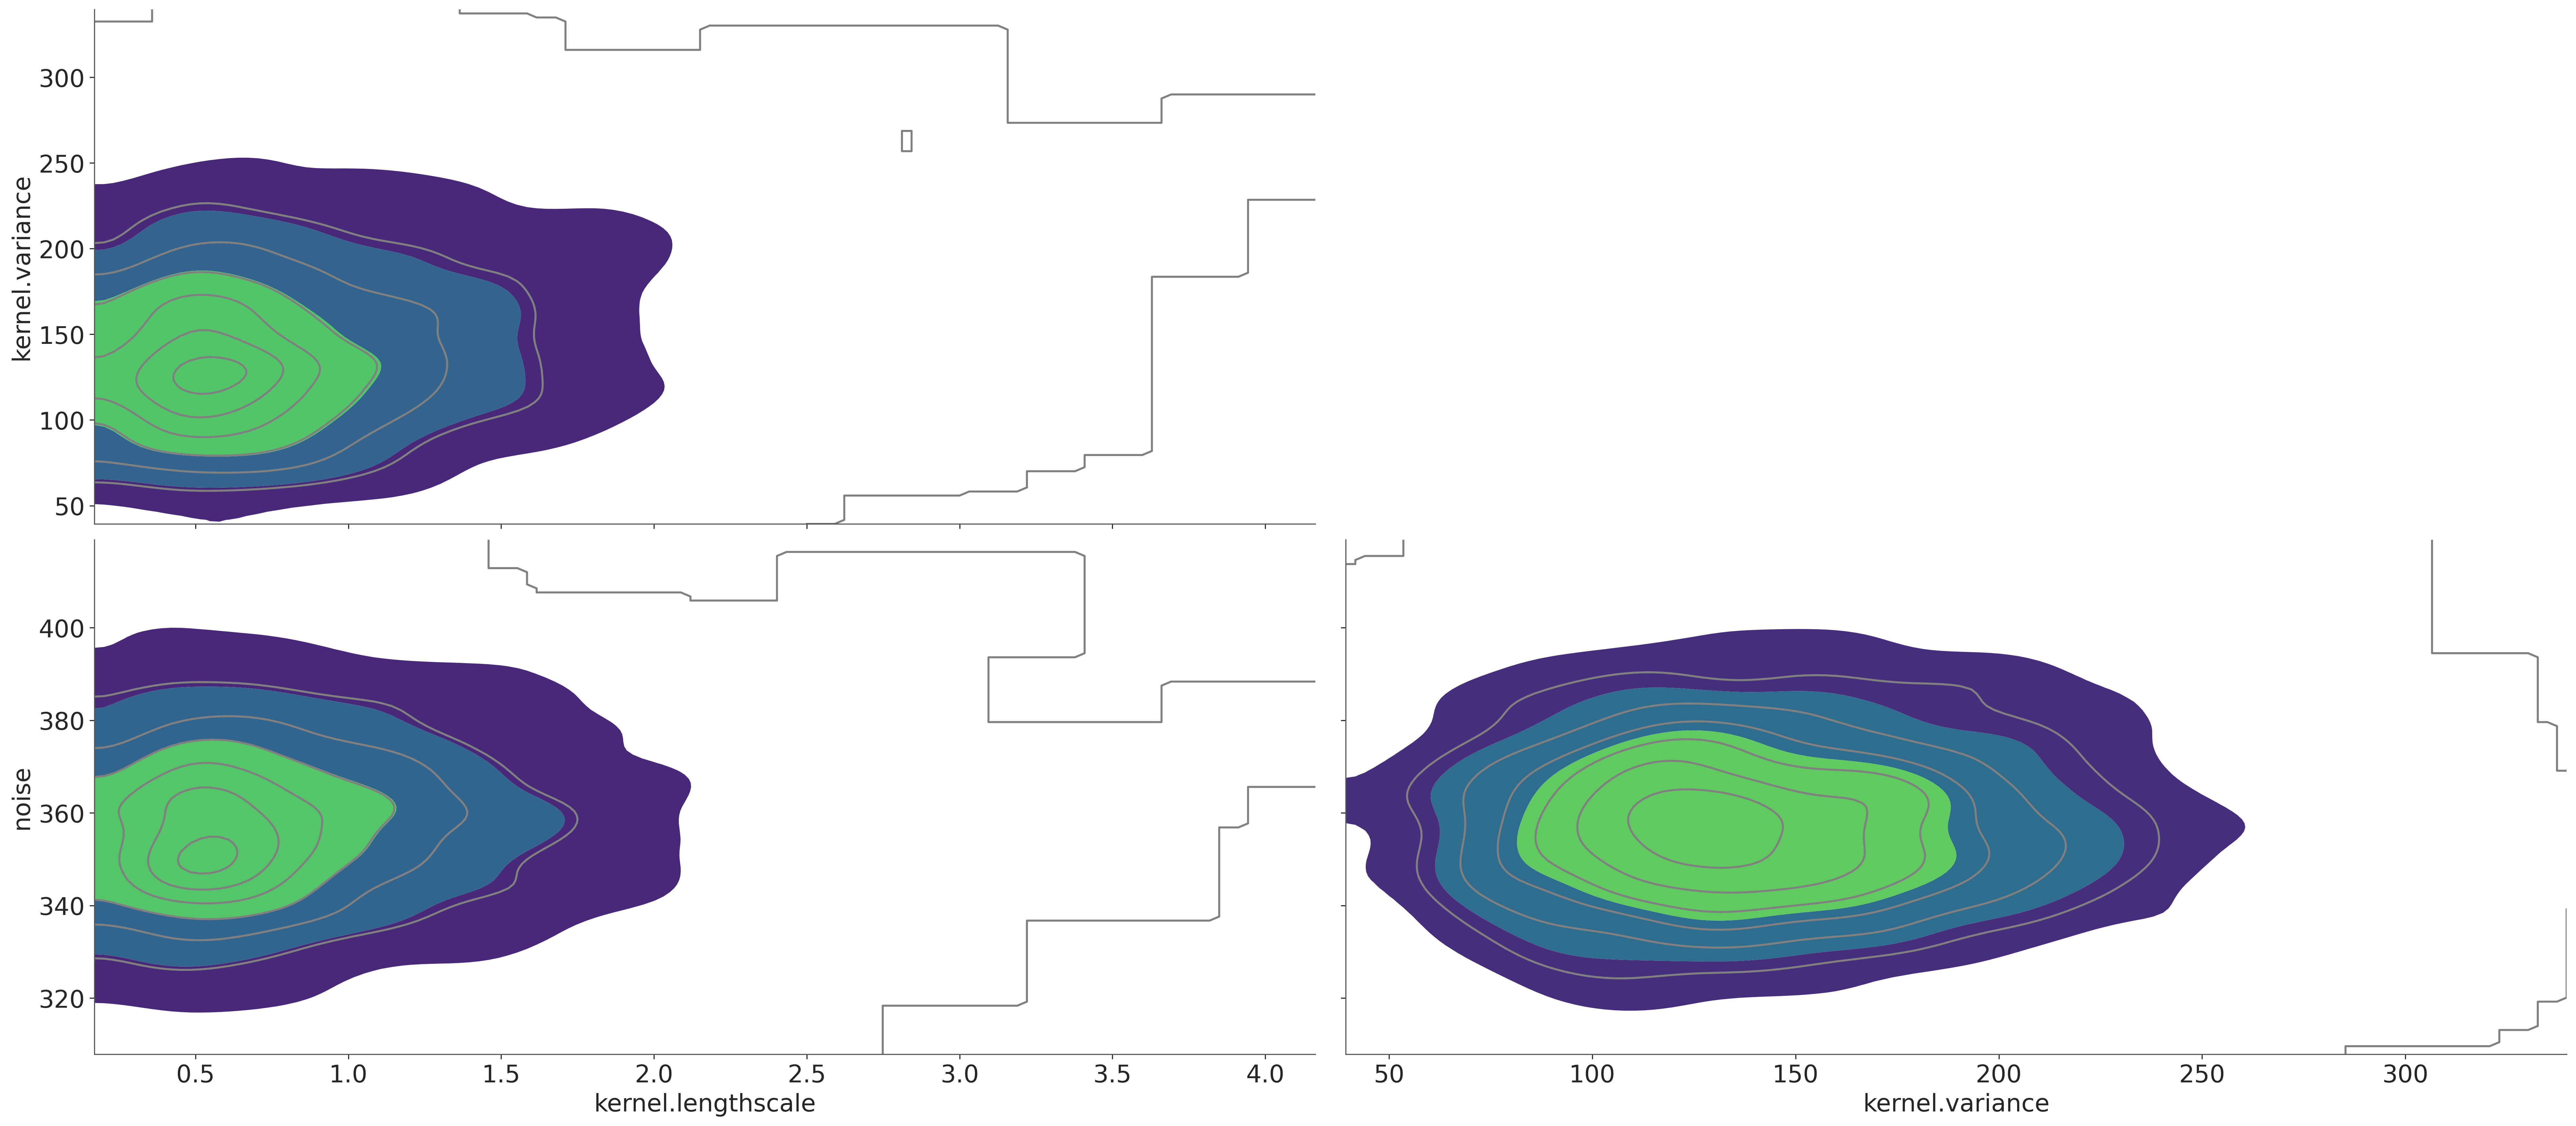

In [17]:
az.plot_pair(pyro_data,kind='kde',divergences=True,textsize=18)

In [18]:
pyro_data_bc=az.from_json("../Arviz_stats/mcmc_bc_flow.json")

In [19]:
az.style.use("arviz-doc")

ax = az.plot_trace(pyro_data_bc,backend='bokeh')

In [20]:
ax = az.plot_density(
    [pyro_data_bc],
    shade=0.1,backend='bokeh'
)